# libraries

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

# Load Data

## Match-Level Data

In [2]:
# 2022-2023 Premier League Scores and Fixtures
url_df = 'https://fbref.com/en/comps/9/2022-2023/schedule/2022-2023-Premier-League-Scores-and-Fixtures'

df = pd.read_html(url_df)[0]
df['Season'] = '2022-2023'
df = df.dropna(subset=['Date'])

# 2023-2024 Premier League Scores and Fixtures
url_df = 'https://fbref.com/en/comps/9/2023-2024/schedule/2023-2024-Premier-League-Scores-and-Fixtures'
df2 = pd.read_html(url_df)[0]
df2['Season'] = '2023-2024'
df2 = df2.dropna(subset=['Date'])

# 2024-2025 Premier League Scores and Fixtures
url_df = 'https://fbref.com/en/comps/9/2024-2025/schedule/2024-2025-Premier-League-Scores-and-Fixtures'
df3 = pd.read_html(url_df)[0]
df3['Season'] = '2024-2025'
df3 = df3.dropna(subset=['Date'])

# 2025-2026 Premier League Scores and Fixtures
url_df = 'https://fbref.com/en/comps/9/schedule/Premier-League-Scores-and-Fixtures'
df4 = pd.read_html(url_df)[0]
df4['Season'] = '2025-2026'
df4 = df4.dropna(subset=['Date'])

# Combine all seasons into one DataFrame
df = pd.concat([df, df2, df3, df4], ignore_index=True)
match_df = df.drop(columns=['Venue', 'Match Report', 'Notes'])

## Load the Player-Level Data

Note that we use the overall **previous season** performance to predict future results

In [3]:
# 2021-2022 Big 5 European Leagues Player Stats
url_df = 'https://fbref.com/en/comps/Big5/2021-2022/stats/players/2021-2022-Big-5-European-Leagues-Stats'
df = pd.read_html(url_df)[0]
df['Season'] = '2022-2023'

# 2022-2023 Big 5 European Leagues Player Stats
url_df = 'https://fbref.com/en/comps/Big5/2022-2023/stats/players/2022-2023-Big-5-European-Leagues-Stats'
df2 = pd.read_html(url_df)[0]
df2['Season'] = '2023-2024'

# 2023-2024 Big 5 European Leagues Player Stats
url_df = 'https://fbref.com/en/comps/Big5/2023-2024/stats/players/2023-2024-Big-5-European-Leagues-Stats'
df3 = pd.read_html(url_df)[0]
df3['Season'] = '2024-2025'

# 2024-2025 Big 5 European Leagues Player Stats
url_df = 'https://fbref.com/en/comps/Big5/2024-2025/stats/players/2023-2024-Big-5-European-Leagues-Stats'
df4 = pd.read_html(url_df)[0]
df4['Season'] = '2025-2026'

player_df = pd.concat([df, df2, df3, df4], ignore_index=True)

# Clean Data

## Player-Level Data

In [4]:
df = player_df.copy()

# rename columns to avoid multi-index label
# remove the first part of the multi-index if it contains 'unnamed'
df.columns = [col[1] if 'unnamed' in col[0].lower() else col for col in df.columns]
df.columns = ['Per90_' + col[1] if 'per 90' in col[0].lower() else col for col in df.columns]
df.columns = ['PT_' + col[1] if 'playing time' in col[0].lower() else col for col in df.columns]
df.columns = [col[1] if 'progression' in col[0].lower() else col for col in df.columns]
df.columns = [col[1] if 'performance' in col[0].lower() else col for col in df.columns]
df.columns = [col[1] if 'expected' in col[0].lower() else col for col in df.columns]
df.columns = [col[0] if 'season' in col[0].lower() else col for col in df.columns]

df['Comp'] = df['Comp'].replace({'eng Premier League': 'EPL',
                                 'fr Ligue 1': 'Ligue 1',
                                'it Serie A': 'Serie A',
                                'de Bundesliga': 'Bundesliga',
                                'es La Liga': 'La Liga'})
# keep only players from the English Premier League (EPL)
df = df[df['Comp'] == 'EPL']

# drop unused columns
df = df.drop(columns=['Rk', 'Born', 'Comp', 'Matches'])


# remove the nations's abbreviation from the player's nation. All the characters before the first capital letter
df['Nation'] = df['Nation'].str.extract(r'([A-Z]{3})', expand=False)

# rank players by position and season based on their Per90_G+A-PK
df['Position'] = df['Pos'].str.split(',').str[0]  # take only the first position if multiple
df['Rank'] = df.groupby(['Season', 'Position'])['Per90_G+A-PK'].rank(ascending=False, method='min').astype(int)
df = df.sort_values(['Season', 'Position', 'Rank'])

df['Per90_G+A-PK'] = df['Per90_G+A-PK'].astype(float)

# partition players into quartiles based on their Per90_G+A-PK by position and season
df['Quartile'] = df.groupby(['Season', 'Position'])['Per90_G+A-PK'].transform(
    lambda x: pd.qcut(x, 4, labels=False, duplicates='drop'))

df = df.groupby(['Season', 'Position', 'Squad', 'Quartile']).agg( num_players = ('Player', 'nunique') ).reset_index()

num_players_in_q4 = df[df['Quartile'] == 3].reset_index()
num_players_in_q3 = df[df['Quartile'] == 2].reset_index()
num_players_in_q2 = df[df['Quartile'] == 1].reset_index()
num_players_in_q1 = df[df['Quartile'] == 0].reset_index()

# pivot the dataframe to have positions-quartiles as columns and seasons and squads as index
num_players_in_q4 = num_players_in_q4.pivot_table(index=['Season', 'Squad'], columns='Position', values='num_players', fill_value=0).reset_index()
num_players_in_q3 = num_players_in_q3.pivot_table(index=['Season', 'Squad'], columns='Position', values='num_players', fill_value=0).reset_index()
num_players_in_q2 = num_players_in_q2.pivot_table(index=['Season', 'Squad'], columns='Position', values='num_players', fill_value=0).reset_index()
num_players_in_q1 = num_players_in_q1.pivot_table(index=['Season', 'Squad'], columns='Position', values='num_players', fill_value=0).reset_index()

# merge the dataframes on Season and Squad
num_player_by_ga_pk = num_players_in_q4.merge(num_players_in_q3, on=['Season', 'Squad'], suffixes=('_Q4', '_Q3'), how='outer').fillna(0)
num_player_by_ga_pk = num_player_by_ga_pk.merge(num_players_in_q2, on=['Season', 'Squad'], suffixes=('', '_Q2'), how='outer').fillna(0)
num_player_by_ga_pk = num_player_by_ga_pk.merge(num_players_in_q1, on=['Season', 'Squad'], suffixes=('', '_Q1'), how='outer').fillna(0)

## Match-Level Data

Functions

In [5]:
def team_view(df):
    # home perspective
    home = pd.DataFrame({
        'Season': df['Season'],
        'MatchID': df['MatchID'],
        'Date': df['Date'],
        'year': df['year'],
        'month': df['month'],
        'day': df['day'],
        'Team': df['Home'],
        'TeamID': df.get('HomeTeamID'),
        'OpponentID': df.get('AwayTeamID'),
        'IsHome': True,
        'GoalsFor': df.get('FullTimeHomeGoals'),
        'GoalsAgainst': df.get('FullTimeAwayGoals'),
        'Shots': df.get('HomeShots'),
        'ShotsOnTarget': df.get('HomeShotsOnTarget'),
        'Corners': df.get('HomeCorners'),
        'Fouls': df.get('HomeFouls'),
        'YellowCards': df.get('HomeYellowCards'),
        'RedCards': df.get('HomeRedCards'),
        'ShotsAgainst': df.get('AwayShots'),
        'ShotsOnTargetAgainst': df.get('AwayShotsOnTarget'),
        'CornersAgainst': df.get('AwayCorners'),
        'FoulsAgainst': df.get('AwayFouls'),
        'YellowCardsAgainst': df.get('AwayYellowCards'),
        'RedCardsAgainst': df.get('AwayRedCards'),
        'HalfTimeResult': df.get('HalfTimeResult')
    })
    # away perspective
    away = pd.DataFrame({
        'Season': df['Season'],
        'MatchID': df['MatchID'],
        'Date': df['Date'],
        'year': df['year'],
        'month': df['month'],
        'day': df['day'],
        'Team': df.get('Away'),
        'TeamID': df.get('AwayTeamID'),
        'OpponentID': df.get('HomeTeamID'),
        'IsHome': False,
        'GoalsFor': df.get('FullTimeAwayGoals'),
        'GoalsAgainst': df.get('FullTimeHomeGoals'),
        'Shots': df.get('AwayShots'),
        'ShotsOnTarget': df.get('AwayShotsOnTarget'),
        'Corners': df.get('AwayCorners'),
        'Fouls': df.get('AwayFouls'),
        'YellowCards': df.get('AwayYellowCards'),
        'RedCards': df.get('AwayRedCards'),
        'ShotsAgainst': df.get('HomeShots'),
        'ShotsOnTargetAgainst': df.get('HomeShotsOnTarget'),
        'CornersAgainst': df.get('HomeCorners'),
        'FoulsAgainst': df.get('HomeFouls'),
        'YellowCardsAgainst': df.get('HomeYellowCards'),
        'RedCardsAgainst': df.get('HomeRedCards'),
        'HalfTimeResult': df.get('HalfTimeResult')
    })
    return pd.concat([home, away], ignore_index=True)

# add outcome from full-time scores (W/L/D from each team's perspective)
def wl_from_scores(row):
    gf = row['GoalsFor']
    ga = row['GoalsAgainst']
    if pd.isna(gf) or pd.isna(ga):
        return None
    if gf > ga:
        return 'W'
    if gf < ga:
        return 'L'
    return 'D'

def points_from_scores(row):
    gf = row['GoalsFor']
    ga = row['GoalsAgainst']
    if pd.isna(gf) or pd.isna(ga):
        return None
    if gf > ga:
        return 3
    if gf < ga:
        return 0
    return 1

In [6]:
# clean the match-level data
df = match_df.copy()

## split the Date into a year, month and date
df['year'] = [int(d.split("-")[0]) for d in df.Date]
df['month'] = [int(d.split("-")[1]) for d in df.Date]
df['day'] = [int(d.split("-")[2]) for d in df.Date]

df['FullTimeHomeGoals'] = [np.nan if pd.isna(x) else int(x.split("–")[0].strip()) for x in df['Score']]
df['FullTimeAwayGoals'] = [np.nan if pd.isna(x) else int(x.split("–")[1].strip()) for x in df['Score']]

## create a stable unique ID for every team (covers Home and Away)
teams = sorted(
    set(df['Home'].dropna().unique()).union(set(df['Away'].dropna().unique()))
)

team_to_id = {name: i for i, name in enumerate(teams, start=1)}


# add ID columns to the match dataframe
df['HomeTeamID'] = df['Home'].map(team_to_id)
df['AwayTeamID'] = df['Away'].map(team_to_id)

# ensure a stable match id
df = df.reset_index(drop=True)
df['MatchID'] = df.index + 1

long_df = team_view(df)

long_df['Outcome'] = long_df.apply(wl_from_scores, axis=1)
long_df['Points'] = long_df.apply(points_from_scores, axis=1)

# sort the data by team ID and match ID and create a new variable indicating the teams' game number since beginning of each season
long_df = long_df.sort_values(['Season', 'TeamID', 'MatchID']).reset_index(drop=True)
long_df['Week'] = long_df.groupby(['Season', 'TeamID']).cumcount() + 1
long_df['Week'] = long_df['Week'].astype(int)

# optional: reorder columns
cols = ['Season', 'MatchID','Date', 'Week','year','month','day','Team','TeamID','IsHome',
        'GoalsFor','GoalsAgainst','Outcome', 'Points']
long_df = long_df[[c for c in cols if c in long_df.columns]]

#For each team-match observation create the lag of each variable
cols = ['IsHome','GoalsFor','GoalsAgainst','Outcome']

for c in cols:
    long_df[f'{c}_lag1'] = long_df.groupby(['Season', 'TeamID'])[c].shift(1)

# optional: create a 3-game rolling mean (uses previous games only)
num_cols = [c for c in cols if pd.api.types.is_numeric_dtype(long_df[c])]
for c in num_cols:
    long_df[f'{c}_roll3'] = long_df.groupby(['Season', 'TeamID'])[c].transform(
        lambda s: s.shift(1).rolling(3, min_periods=1).mean()
    )

# merge the player-level data (num_players_in_q4) into the match-level data (long_df)
long_df = long_df.merge(num_players_in_q4[['Season', 'Squad', 'FW']],
                        left_on=['Season', 'Team'],
                        right_on=['Season', 'Squad'],
                        how='left')
long_df['FW'].fillna(0, inplace=True)
long_df.drop(columns=['Squad'], inplace=True)

C:\Users\amirh\AppData\Local\Temp\ipykernel_16452\1867750674.py:61: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  long_df['FW'].fillna(0, inplace=True)


In [7]:
long_df

,Season,MatchID,Date,Week,year,month,day,Team,TeamID,IsHome,...,Outcome,Points,IsHome_lag1,GoalsFor_lag1,GoalsAgainst_lag1,Outcome_lag1,IsHome_roll3,GoalsFor_roll3,GoalsAgainst_roll3,FW
0,2022-2023,1,2022-08-05,1,2022,8,5,Arsenal,1,False,...,W,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1,2022-2023,13,2022-08-13,2,2022,8,13,Arsenal,1,True,...,W,3.0,False,2.0,0.0,W,0.000000,2.0,0.000000,2.0
2,2022-2023,26,2022-08-20,3,2022,8,20,Arsenal,1,False,...,W,3.0,True,4.0,2.0,W,0.500000,3.0,1.000000,2.0
3,2022-2023,37,2022-08-27,4,2022,8,27,Arsenal,1,True,...,W,3.0,False,3.0,0.0,W,0.333333,3.0,0.666667,2.0
4,2022-2023,47,2022-08-31,5,2022,8,31,Arsenal,1,True,...,W,3.0,True,2.0,1.0,W,0.666667,3.0,1.000000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3035,2025-2026,1476,2026-04-25,34,2026,4,25,Wolves,25,True,...,None,NaN,False,NaN,NaN,None,0.333333,NaN,NaN,1.0
3036,2025-2026,1482,2026-05-02,35,2026,5,2,Wolves,25,True,...,None,NaN,True,NaN,NaN,None,0.333333,NaN,NaN,1.0
3037,2025-2026,1492,2026-05-09,36,2026,5,9,Wolves,25,False,...,None,NaN,True,NaN,NaN,None,0.666667,NaN,NaN,1.0
3038,2025-2026,1506,2026-05-17,37,2026,5,17,Wolves,25,True,...,None,NaN,False,NaN,NaN,None,0.666667,NaN,NaN,1.0


# Data Exploration

Histogram of winning against the rolling average number of goals for

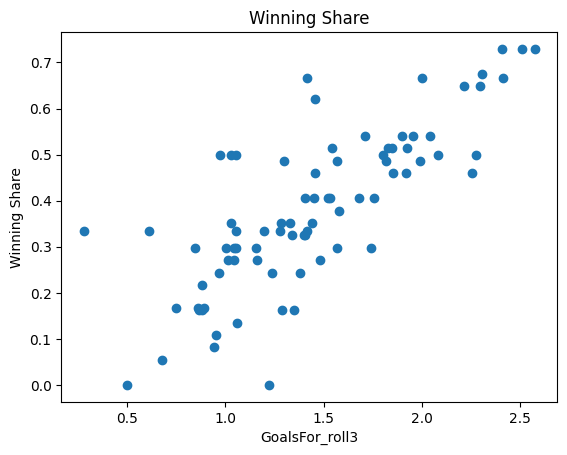

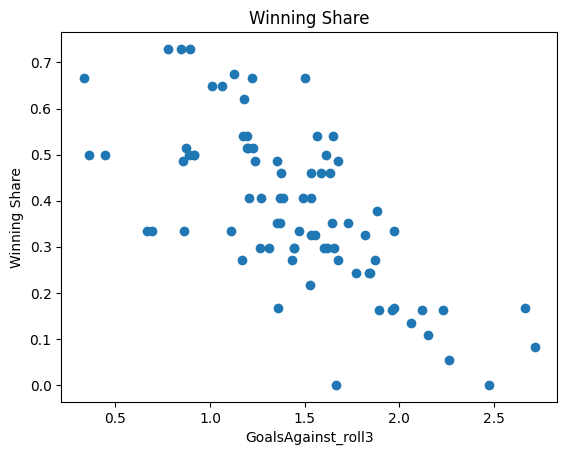

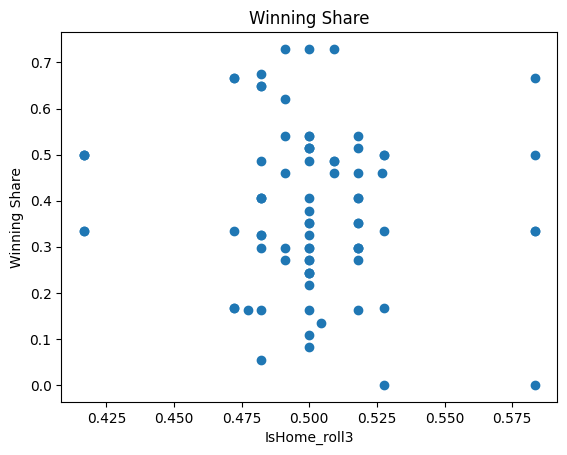

In [8]:
data_table = long_df[['Season','TeamID','Outcome', 'GoalsFor_roll3', 'GoalsAgainst_roll3', 'IsHome_roll3']].dropna()
data_table.loc[:, 'Win'] = 0
data_table.loc[data_table['Outcome'] == 'W', 'Win'] = 1
data_table = data_table.groupby(['Season', 'TeamID']).agg(Win = ('Win', 'mean'),
                                                          IsHome_roll3 = ('IsHome_roll3', 'mean'),
                                                          GoalsFor_roll3 = ('GoalsFor_roll3', 'mean'),
                                                          GoalsAgainst_roll3 = ('GoalsAgainst_roll3', 'mean')
                                                          ).reset_index()
cols = ['GoalsFor_roll3', 'GoalsAgainst_roll3', 'IsHome_roll3']
for col in cols:
    plt.scatter(x=data_table[col], y=data_table['Win'])

    plt.xlabel(f'{col}')
    plt.ylabel('Winning Share')
    plt.title('Winning Share')
    plt.show()

Distribution of outcomes for home games

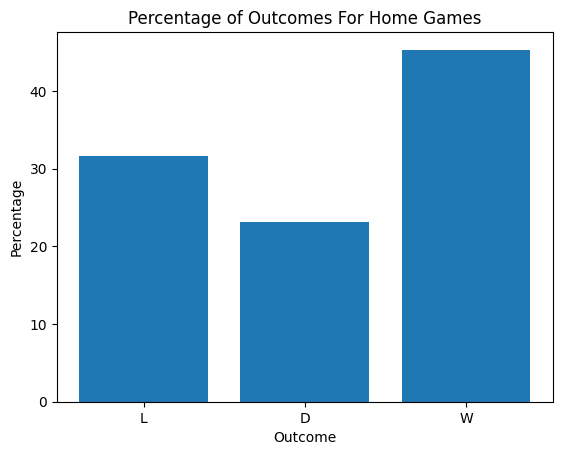

In [9]:
# for season in long_df['Season'].unique():
ishome_stats = long_df.groupby(['IsHome', 'Outcome']).agg(num=('TeamID', 'count')).reset_index()
ishome_stats = ishome_stats[ishome_stats['IsHome'] == True]

desired_order = ['L', 'D', 'W']
ishome_stats['Outcome'] = pd.Categorical(ishome_stats['Outcome'], categories=desired_order, ordered=True)
ishome_stats = ishome_stats.sort_values('Outcome').reset_index(drop=True)

# Calculate the percentage of each outcome
ishome_stats['percent'] = ishome_stats['num'] / ishome_stats['num'].sum() * 100

# Plot the horizontal bar chart
plt.bar(ishome_stats['Outcome'], ishome_stats['percent'])
plt.xlabel('Outcome')
plt.ylabel('Percentage')
plt.title(f'Percentage of Outcomes For Home Games')
plt.show()


# Estimation

## Models:
* K-Nearest Neighbour Model
* logit Regression
* XGBoost

In [46]:
# Build a small, reusable estimation pipeline so you can easily add/remove explanatory vars
#  - Change the FEATURES list in the runner cell to include/remove variables.
#  - Roll-3 features (ending with '_roll3') are discovered automatically.

roll3_cols = [col for col in long_df.columns if col.endswith('_roll3')]

# Default feature set (you can edit the runner cell to change which sets to try)
DEFAULT_FEATURES = ['Week', 'IsHome', 'FW'] + roll3_cols  # example: ['Week','IsHome','GoalsFor_roll3']

CATEGORICAL_VARS = ['Week']  # treat Week as categorical


def build_dataset(df, features=None, categorical=CATEGORICAL_VARS):
    """Return X (with dummies applied), y, label encoder, label mapping, used raw features, and model columns.

    - 'features' is a list of raw dataframe columns you want to use (e.g. ['Week','IsHome','GoalsFor_roll3']).
    - categorical: list of columns that should be one-hot encoded.
    The function drops rows with NA in Outcome or any chosen raw feature before encoding.
    """
    if features is None:
        features = ['Week', 'IsHome'] + [c for c in df.columns if c.endswith('_roll3')]
    # ensure features exist in df
    present = [f for f in features if f in df.columns]
    missing = [f for f in features if f not in df.columns]
    if missing:
        print("Warning: the following features are missing from the dataframe and will be ignored:", missing)
    cols = ['Outcome'] + present
    data = df[cols].dropna().copy()

    # Separate X_raw and Y
    X_raw = data[present].copy()
    Y = data['Outcome']

    # One-hot encode categorical variables (only those present)
    cat_present = [c for c in categorical if c in X_raw.columns]
    if cat_present:
        X = pd.get_dummies(X_raw, columns=cat_present, dummy_na=False, drop_first=False)
    else:
        X = X_raw.astype(float)

    # Keep track of final model columns to ensure consistent prediction later
    model_columns = X.columns.tolist()

    # Ensure numeric dtype for downstream scalers/models
    X = X.astype(float)

    le = LabelEncoder()
    y = le.fit_transform(Y)
    label_mapping = {cls: int(i) for i, cls in enumerate(le.classes_)}
    return X, y, le, label_mapping, model_columns


def safe_train_test_split(X, y, test_size=0.2, random_state=42):
    try:
        return train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)
    except Exception as e:
        print("Stratified split failed (reason):", e)
        print("Falling back to a regular random split without stratification.")
        return train_test_split(X, y, test_size=test_size, random_state=random_state)


def train_models(X_train, y_train, use_xgb=True, use_rf=True):
    """Train KNN (scaled), Logistic (scaled), RandomForest (unscaled), and optionally XGBoost (unscaled).
    Returns a dict with trained models and the scaler.
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_scaled, y_train)

    # Logistic regression (try to use penalty='none' when available)
    log_reg = LogisticRegression(max_iter=2000)
    log_reg.fit(X_train_scaled, y_train)

    # Random Forest
    rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_clf.fit(X_train, y_train)  # RF can handle unscaled inputs

    # XGBoost
    xgb_clf = None
    if use_xgb:
        try:
            xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
            xgb_clf.fit(X_train, y_train)  # XGBoost can handle unscaled inputs
        except Exception as e:
            print("XGBoost training skipped (error):", e)
            xgb_clf = None

    return {'scaler': scaler, 'knn': knn, 'log_reg': log_reg, 'rf': rf_clf, 'xgb': xgb_clf}


def evaluate(models, X_test, y_test):
    scaler = models['scaler']
    X_test_scaled = scaler.transform(X_test)
    results = {}
    results['knn_acc'] = accuracy_score(y_test, models['knn'].predict(X_test_scaled))
    results['logreg_acc'] = accuracy_score(y_test, models['log_reg'].predict(X_test_scaled))
    # Random Forest (unscaled inputs)
    if models.get('rf') is not None:
        try:
            results['rf_acc'] = accuracy_score(y_test, models['rf'].predict(X_test))
        except Exception as e:
            print("RF evaluation failed:", e)
            results['rf_acc'] = None
    # XGBoost (unscaled inputs)
    if models.get('xgb') is not None:
        try:
            results['xgb_acc'] = accuracy_score(y_test, models['xgb'].predict(X_test))
        except Exception as e:
            print("XGB evaluation failed:", e)
            results['xgb_acc'] = None
    return results


def predict_on_long_df(df, raw_features, model_columns, models, le, categorical=CATEGORICAL_VARS):
    """Create dummies for categorical vars on the full df using the raw_features list,
    then reindex to model_columns (adding missing columns with zeros) before scaling and predicting.
    """
    present = [f for f in raw_features if f in df.columns]
    X_all_raw = df[present].copy()

    # One-hot encode categorical variables present in the raw features
    cat_present = [c for c in categorical if c in X_all_raw.columns]
    if cat_present:
        X_all = pd.get_dummies(X_all_raw, columns=cat_present, dummy_na=False, drop_first=False)
    else:
        X_all = X_all_raw.copy()

    # Reindex to match the model training columns, fill missing with 0
    X_all = X_all.reindex(columns=model_columns).astype(float).fillna(0)

    scaler = models['scaler']
    X_scaled = scaler.transform(X_all)

    df['Predicted_knn'] = le.inverse_transform(models['knn'].predict(X_scaled))
    df['Predicted_logreg'] = le.inverse_transform(models['log_reg'].predict(X_scaled))
    if models.get('rf') is not None:
        try:
            df['Predicted_rf'] = le.inverse_transform(models['rf'].predict(X_all))
        except Exception as e:
            print("RF prediction skipped, error:", e)
    if models.get('xgb') is not None:
        try:
            df['Predicted_xgb'] = le.inverse_transform(models['xgb'].predict(X_all))
        except Exception as e:
            print("XGB prediction skipped, error:", e)
    return df

In [52]:
FEATURES_list ={
    'feature1': ['Week', 'IsHome', 'GoalsFor_roll3', 'GoalsAgainst_roll3'],
    'feature2': ['Week', 'IsHome', 'FW', 'GoalsFor_roll3', 'GoalsAgainst_roll3'],
}

for name, FEATURES in FEATURES_list.items():
    print(f"\n=== Running pipeline with feature set: {name} ===")
    X, y, le, label_mapping, used_features = build_dataset(long_df, FEATURES)
    print("Used features:", used_features)
    print("Label mapping:", label_mapping)

    X_train, X_test, y_train, y_test = safe_train_test_split(X, y, test_size=0.2, random_state=42)

    models = train_models(X_train, y_train, use_xgb=True)

    results = evaluate(models, X_test, y_test)
    print("Evaluation results:", results)

    long_df = predict_on_long_df(long_df, used_features, X_test.columns.tolist(), models, le)

    # Quick confusion matrices for the test set
    sc = models['scaler']
    X_test_scaled = sc.transform(X_test)
    print("KNN classification report:")
    print(classification_report(y_test, models['knn'].predict(X_test_scaled), target_names=le.classes_))
    print("Logistic Regression classification report:")
    print(classification_report(y_test, models['log_reg'].predict(X_test_scaled), target_names=le.classes_))
    print("XGBoost classification report:")
    print(classification_report(y_test, models['xgb'].predict(X_test), target_names=le.classes_))


=== Running pipeline with feature set: feature1 ===
Used features: ['IsHome', 'GoalsFor_roll3', 'GoalsAgainst_roll3', 'Week_2', 'Week_3', 'Week_4', 'Week_5', 'Week_6', 'Week_7', 'Week_8', 'Week_9', 'Week_10', 'Week_11', 'Week_12', 'Week_13', 'Week_14', 'Week_15', 'Week_16', 'Week_17', 'Week_18', 'Week_19', 'Week_20', 'Week_21', 'Week_22', 'Week_23', 'Week_24', 'Week_25', 'Week_26', 'Week_27', 'Week_28', 'Week_29', 'Week_30', 'Week_31', 'Week_32', 'Week_33', 'Week_34', 'Week_35', 'Week_36', 'Week_37', 'Week_38']
Label mapping: {'D': 0, 'L': 1, 'W': 2}


c:\Users\amirh\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:59:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Evaluation results: {'knn_acc': 0.4166666666666667, 'logreg_acc': 0.4722222222222222, 'rf_acc': 0.3952991452991453, 'xgb_acc': 0.41452991452991456}
KNN classification report:
              precision    recall  f1-score   support

           D       0.24      0.24      0.24       108
           L       0.48      0.55      0.51       180
           W       0.46      0.39      0.42       180

    accuracy                           0.42       468
   macro avg       0.39      0.39      0.39       468
weighted avg       0.42      0.42      0.41       468

Logistic Regression classification report:
              precision    recall  f1-score   support

           D       0.43      0.03      0.05       108
           L       0.48      0.59      0.53       180
           W       0.47      0.62      0.53       180

    accuracy                           0.47       468
   macro avg       0.46      0.41      0.37       468
weighted avg       0.46      0.47      0.42       468

XGBoost classificati

c:\Users\amirh\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:59:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Evaluation results: {'knn_acc': 0.40384615384615385, 'logreg_acc': 0.4658119658119658, 'rf_acc': 0.44017094017094016, 'xgb_acc': 0.405982905982906}
KNN classification report:
              precision    recall  f1-score   support

           D       0.23      0.24      0.24       108
           L       0.46      0.51      0.49       180
           W       0.45      0.39      0.42       180

    accuracy                           0.40       468
   macro avg       0.38      0.38      0.38       468
weighted avg       0.41      0.40      0.40       468

Logistic Regression classification report:
              precision    recall  f1-score   support

           D       0.38      0.05      0.08       108
           L       0.47      0.58      0.52       180
           W       0.47      0.60      0.52       180

    accuracy                           0.47       468
   macro avg       0.44      0.41      0.38       468
weighted avg       0.45      0.47      0.42       468

XGBoost classificati

In [50]:
# long_df[['Outcome', 'Predicted_knn', 'Predicted_logreg', 'Predicted_rf', 'Predicted_xgb']]
long_df[(long_df['Season'] == '2025-2026') & (long_df['Week'] == 7)][['Team', 'Outcome', 'Predicted_knn', 'Predicted_logreg', 'Predicted_rf', 'Predicted_xgb']]

,Team,Outcome,Predicted_knn,Predicted_logreg,Predicted_rf,Predicted_xgb
2286,Arsenal,W,W,W,W,W
2324,Aston Villa,W,W,W,W,W
2362,Bournemouth,W,D,W,W,W
2400,Brentford,L,D,W,W,W
2438,Brighton,D,L,L,W,L
2476,Burnley,L,L,L,L,L
2514,Chelsea,W,L,W,L,W
2552,Crystal Palace,L,W,L,W,W
2590,Everton,W,W,W,W,W
2628,Fulham,L,L,L,L,L


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

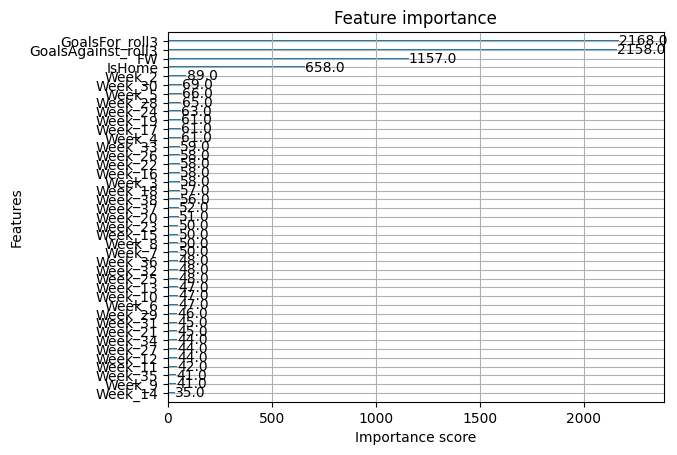

In [51]:
xgb.plot_importance(models['xgb'])